In [34]:
import numpy as np
import pandas as pd
from selenium import webdriver
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Scraping tech in Asia Ed-tech firms

In [37]:
url = 'https://www.techinasia.com/startups?country_name%5B%5D=Singapore&country_name%5B%5D=Indonesia&country_name%5B%5D=Vietnam&country_name%5B%5D=Malaysia&industry_name%5B%5D=Education%20Tech'
browser = webdriver.Chrome()
browser.get(url)

In [29]:
results_xpath = '//*[@id="app"]/div/div/div/div/div/div[2]/div[2]'

In [38]:
startups = []
description = []
funding = []
tags = []

scraping = True
page = 1
while (scraping == True):
    print 'Scraping from page %d ...' % page
    get_data()
    try:
        page += 1
        turn_page(page)
        
    except:
        print 'Last page scraped: %d' % page
        browser.close()
        scraping = False
        
print 'Total Companies: %d, Descriptions: %d, Funding information: %d, Tags: %d' % (len(startups), len(description), len(funding), len(tags))    

Scraping from page 1 ...
Scraping from page 2 ...
Scraping from page 3 ...
Scraping from page 4 ...
Scraping from page 5 ...
Scraping from page 6 ...
Scraping from page 7 ...
Scraping from page 8 ...
Scraping from page 9 ...
Scraping from page 10 ...
Scraping from page 11 ...
Last page scraped: 12
Total Companies: 321, Descriptions: 321, Funding information: 321, Tags: 321


In [36]:
def get_data():
    companies = browser.find_elements_by_class_name("search-results")
    names = companies[0].find_elements_by_class_name("media-body")
    for n in names:
        title = n.find_element_by_css_selector('a').text
        startups.append(title)
        des_fund_tag = n.find_elements_by_class_name('search-results__item-meta')
        des = des_fund_tag[0].text
        description.append(des)
        if (len(des_fund_tag) == 3):
            funds = des_fund_tag[1].text
            industry = des_fund_tag[2].text
        else:
            funds = np.nan
            industry = des_fund_tag[1].text
        funding.append(funds)
        tags.append(industry)
        
def turn_page(p):
    page_num = str(p)
    browser.find_element_by_link_text(page_num).click()

In [39]:
df = pd.DataFrame()
df['company'] = startups
df['descriptions'] = description
df['funding'] = funding
df['tags'] = tags
df.head()

,company,descriptions,funding,tags
0,Gnowbe,Gnowbe is a disruptive mobile learning solutio...,"Latest Funding: Seed / $1,700,000 / May '17","Industries: Education Tech, Enterprise Applica..."
1,DANAdidik,DANAdidik is a Peer-to-Peer Lending (P2PL) for...,"Latest Funding: Seed / $50,000 / May '17","Industries: Education Tech, Crowdfunding"
2,HarukaEdu,HarukaEdu is education portal where users can ...,"Latest Funding: Series B / $2,200,000 / Nov '16","Industries: Education Tech, Adaptive Learning"
3,Nhance App,Nhance is a mobile learning platform which tra...,"Latest Funding: Seed / $300,000 / Aug '16","Industries: Education Tech, Educational Games"
4,Tueetor,"Tueetor is a free, online marketplace that con...","Latest Funding: Undisclosed / $1,480,000 / Aug...","Industries: Education Tech, Tutor Services"


In [46]:
for col in df.columns:
    df[col] = df[col].str.encode('utf-8')

In [47]:
df.to_csv('edtech_tia.csv')

## Pre-processing and LDA

In [1]:
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulmahtani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rahulmahtani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahulmahtani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rahulmahtani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
import numpy as np
import pandas as pd
from selenium import webdriver
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_in = pd.read_csv('edtech_tia.csv')
df_in.drop("Unnamed: 0", axis=1, inplace=True)
df_in.head()

,company,descriptions,funding,tags
0,Gnowbe,Gnowbe is a disruptive mobile learning solutio...,"Latest Funding: Seed / $1,700,000 / May '17","Industries: Education Tech, Enterprise Applica..."
1,DANAdidik,DANAdidik is a Peer-to-Peer Lending (P2PL) for...,"Latest Funding: Seed / $50,000 / May '17","Industries: Education Tech, Crowdfunding"
2,HarukaEdu,HarukaEdu is education portal where users can ...,"Latest Funding: Series B / $2,200,000 / Nov '16","Industries: Education Tech, Adaptive Learning"
3,Nhance App,Nhance is a mobile learning platform which tra...,"Latest Funding: Seed / $300,000 / Aug '16","Industries: Education Tech, Educational Games"
4,Tueetor,"Tueetor is a free, online marketplace that con...","Latest Funding: Undisclosed / $1,480,000 / Aug...","Industries: Education Tech, Tutor Services"


In [5]:
df_in['cleaned'] = df_in['descriptions'].apply(lambda x:''.join([i for i in x 
                                                  if i not in string.punctuation]))

In [6]:
import lda
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

test = df_in['cleaned']
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(test)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [7]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [8]:
# encoding: utf-8
test2 = [clean(doc).split() for doc in df_in['descriptions'].str.decode("utf8")]

In [9]:
tfidf_result = pd.DataFrame()
tfidf_result['word'] = tfidf_feature_names 
tfidf_result['score'] = tfidf_vectorizer.idf_
# most generic words
print tfidf.shape
tfidf_result.sort_values(by=['score'], ascending=True).head(10)

(321, 471)


,word,score
292,online,2.470486
133,education,2.484092
313,platform,2.569859
246,learning,2.584897
410,students,2.785567
440,training,3.248191
244,learn,3.442347
211,indonesia,3.555676
301,parents,3.596498
82,company,3.596498


In [10]:
low_scores = tfidf_result.sort_values(by=['score'], ascending=True)['word'][:30]

In [11]:
# least generic words
tfidf_result.sort_values(by=['score'], ascending=False).head(10)

,word,score
356,relationships,5.675939
154,enhances,5.675939
143,employees,5.675939
144,empower,5.675939
145,empowering,5.675939
146,enables,5.675939
335,projects,5.675939
148,encourage,5.675939
333,progress,5.675939
150,engaged,5.675939


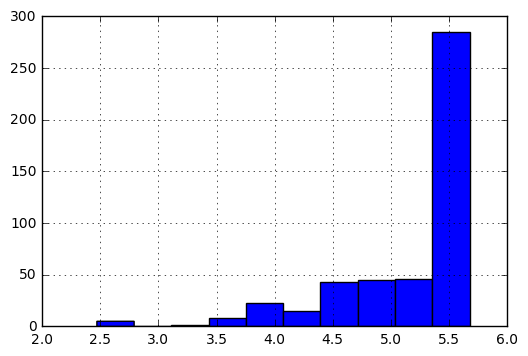

In [12]:
tfidf_result.score.hist()

In [60]:
def clean_with_tfidf(doc):
    high_tfidf = [w for w in doc.lower().split() if w not in low_scores]
    stop_free = " ".join([i for i in high_tfidf if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [61]:
test3 = [clean_with_tfidf(doc).split() for doc in df_in['descriptions'].str.decode("utf8")]

In [155]:
def clean_all(doc):
    phrase = nltk.word_tokenize(doc)
    tags = tags = nltk.pos_tag(phrase)
    keys = [k[0] for k in tags if k[1] == 'NNS' or k[1] == 'JJ' or k[1] == 'NN']
    stop_free = [i.lower() for i in keys if i not in stop]
    high_tfidf = " ".join(w for w in stop_free if w not in low_scores)
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in high_tfidf.split())
    return normalized

In [156]:
test4 = [clean_all(doc).split() for doc in df_in['descriptions'].str.decode("utf8")]

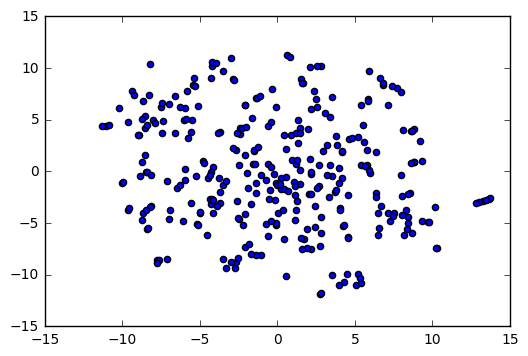

In [157]:
from sklearn.decomposition import TruncatedSVD
from tsne import bh_sne
svd = TruncatedSVD(n_components=20, random_state=0)
svd_tfidf = svd.fit_transform(tfidf)

# t-sne after svd

vis_data = bh_sne(svd_tfidf)
tsne_x = vis_data[:, 0]
tsne_y = vis_data[:, 1]
plt.scatter(tsne_x, tsne_y)
plt.show()

In [176]:
# test: default, test2: normalised, test3: normalised+high_tfidf, test4: with pos tags
import scipy
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(test4)
dtm = [dictionary.doc2bow(doc) for doc in test4]
doc_terms = scipy_csc_matrix = gensim.matutils.corpus2csc(dtm)
doc_terms = doc_terms.T.astype(np.int64)


INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(809 unique tokens: [u'paperless', u'part-time', u'code', u'chinese', u'maximum']...) from 321 documents (total 2361 corpus positions)


In [197]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
counts = count_vectorizer.fit_transform(test)
count_feature_names = count_vectorizer.get_feature_names()

n_topics = 15
n_iter = 1000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
# use doc-terms for normalised version, otherwise use counts 
X_topics = lda_model.fit_transform(doc_terms)

INFO:lda:n_documents: 321
INFO:lda:vocab_size: 809
INFO:lda:n_words: 2361
INFO:lda:n_topics: 15
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -27028
INFO:lda:<10> log likelihood: -18050
INFO:lda:<20> log likelihood: -17767
INFO:lda:<30> log likelihood: -17542
INFO:lda:<40> log likelihood: -17436
INFO:lda:<50> log likelihood: -17399
INFO:lda:<60> log likelihood: -17383
INFO:lda:<70> log likelihood: -17403
INFO:lda:<80> log likelihood: -17301
INFO:lda:<90> log likelihood: -17340
INFO:lda:<100> log likelihood: -17303
INFO:lda:<110> log likelihood: -17322
INFO:lda:<120> log likelihood: -17222
INFO:lda:<130> log likelihood: -17291
INFO:lda:<140> log likelihood: -17273
INFO:lda:<150> log likelihood: -17210
INFO:lda:<160> log likelihood: -17287
INFO:lda:<170> log likelihood: -17332
INFO:lda:<180> log likelihood: -17239
INFO:lda:<190> log likelihood: -17308
INFO:lda:<200> log likelihood: -17168
INFO:lda:<210> log likelihood: -17197
INFO:lda:<220> log likelihood: -17204
INFO:lda:<230> log 

In [65]:
'''
topic_summaries = []
topic_word = lda_model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(count_feature_names)[np.argsort(topic_dist)][:-(8+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
'''

"\ntopic_summaries = []\ntopic_word = lda_model.topic_word_\n\nfor i, topic_dist in enumerate(topic_word):\n    topic_words = np.array(count_feature_names)[np.argsort(topic_dist)][:-(8+1):-1]\n    topic_summaries.append(' '.join(topic_words))\n    print('Topic {}: {}'.format(i, ' '.join(topic_words)))\n"

In [198]:
dictionary_array = []
for i in dictionary:
    dictionary_array.append(dictionary[i])

# use count_feature_names or dictionary array 
topic_summaries = []
topic_word = lda_model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(dictionary_array)[np.argsort(topic_dist)][:-(15+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('%d: %s' % (i, ' '.join(topic_words)))

0: comic subscription program charge level organisation pre multimedia investing enhancement template collection combination open edtech
1: perfect train publication charge teacher choice assessment apprentice development japanese critique start-up extracurricular life aspect
2: bank sign full specialist chuyên q-journal private alternative license exercise degree academy manage eductory international
3: izzilearn environment kiến next challenge extraordinary teacher institution place word baby talent luggage feature retail
4: adult professional xseed era izzilearn assessment exercise corporates destination japanese specialised smiletutor support peope root
5: charge environment freelance imaginable young proprietary experience finance allow tueetor teaching full available program return
6: stock choice robot useful direct positive total vực coding proprietary diverse cooking exercise post- effective
7: bank izzilearn citizen cost environment sponsor 9-5 word electronics tech sign prof

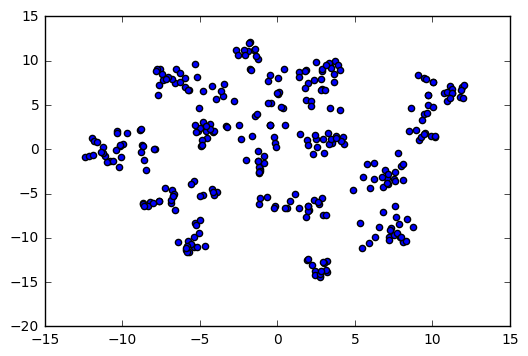

In [199]:
lda_data = bh_sne(X_topics)
lda_x = lda_data[:, 0]
lda_y = lda_data[:, 1]
plt.scatter(lda_x, lda_y)
plt.show()

In [200]:
topics = lda_model.doc_topic_
topic_keys = []
for i, v in enumerate(df_in['descriptions']):
    topic_keys.append(topics[i].argmax())
    
print len(topic_keys)

321


In [201]:
df_in['lda_topics'] = topic_keys
df_in['lda_x'] = lda_data[:, 0]
df_in['lda_y'] = lda_data[:, 1]

In [205]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

Loading BokehJS ...

In [203]:
plot_lda = bp.figure(plot_width=700, plot_height=600, title="EdTech LDA Clusters (TechInAsia)",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [206]:
datasource = ColumnDataSource(df_in)
plot_lda.scatter(source=datasource, x='lda_x', y='lda_y', color=colormap[df_in['lda_topics']])

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"name": "@company", "description": "@descriptions", "funding":"@funding"}
show(plot_lda)

In [207]:
df_in.to_csv('tia_edtech_clusters.csv')